In [1]:
from cell.cell import Cell
from substrate.substrates import Substrate
from box.sim_box import SimulationBox

import numpy as np
import matplotlib.pyplot as plt


In [2]:
def plot_cell(cell, L_box=50, i=None, save=False):
    plt.figure(figsize=(8, 3), dpi=100)
    plt.subplot(121)
    plt.imshow(
    cell.phi, extent=[0, L_box, 0, L_box], origin="lower", cmap="Blues"
    )
    cbar = plt.colorbar()
    cbar.set_label(r"$\phi$")
    plt.contour(
        cell.phi,
        levels=[0.5],
        extent=[0, L_box, 0, L_box],
        origin="lower",
        linewidths=[3],
        colors=["black"],
    )

    plt.subplot(122)
    plt.imshow(
    cell.p_field, extent=[0, L_box, 0, L_box], origin="lower", cmap="coolwarm"
    )
    cbar = plt.colorbar()
    cbar.set_label(r"$\mathbb{P}\equiv \phi \rho$")
    plt.contour(
        cell.phi,
        levels=[0.5],
        extent=[0, L_box, 0, L_box],
        origin="lower",
        linewidths=[3],
        colors=["black"],
    )

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    if save:
        plt.savefig(f"out/img_{i}.png")
        plt.close()
    else:
        plt.show()

### Build a cell

In [3]:
N_mesh, L_box = 200, 50

# define base substrate
simbox = SimulationBox("../configs/simbox.yaml")
sub = Substrate(N_mesh, L_box, xi=0.2)
chi = sub.two_state_sub()

config_file = "../configs/integrins/grid_id0/cell0.yaml"

cell = Cell(config_file, simbox)
cell.W = 0.5 * cell.g * chi


# Polarization field

In [4]:
def update_pol_field(cell, dphi_dt, D):
    p_field = cell.p_field
    phi = cell.phi
    tau_d = 1
    dt = cell.simbox.dt
    dx = cell.simbox.dx
    noise = np.sqrt(4 * D**2 * dt / dx**2) * np.random.randn(*phi.shape)
    return p_field + dt * phi * dphi_dt - dt / tau_d * p_field + noise * phi

In [5]:
from potential.force import Force
from helper_functions import helper_functions as ha

force_calculator = Force("../configs/energy.yaml")
dt = cell.simbox.dt

def update(cell, i, s):
    grad_x, grad_y, _ = ha.compute_gradients(cell.phi, cell.simbox.dx)
    grad_phi = np.array([grad_x, grad_y])
    eta = cell.eta
    phi = cell.phi
    p_field = cell.p_field
    
    # phi_(n+1)
    # CH and area energy terms
    phi_i_next, dF_dphi = ha._update_field(cell, grad_phi, force_calculator)
    dphi_dt = (phi_i_next - phi) / dt

    # compute forces at time n
    fx_thermo = dF_dphi * grad_x
    fy_thermo = dF_dphi * grad_y

    norm_grad_phi = np.sqrt(np.sum(grad_phi * grad_phi, axis=0))
    n_field = -1 * grad_phi / (norm_grad_phi + 1e-10)
    A = 100
    fx_motil = A * p_field * phi**2 * (1-phi)**2 * n_field[0]
    fy_motil = A * p_field * phi**2 * (1-phi)**2 * n_field[1]

    # UPDATE class variables now
    cell.phi = phi_i_next
    cell.vx = (fx_thermo + fx_motil) / eta
    cell.vy = (fy_thermo + fy_motil) / eta
    cell.p_field = update_pol_field(cell, dphi_dt, D=0.1)

    if i % s == 0:
        plot_cell(cell, i=i, save=True)

    

In [7]:
cell = Cell(config_file, simbox)

p_field = np.zeros(shape=cell.phi.shape)
p_field[70:120, 110:120] = 1
p_field *= cell.phi
cell.p_field = p_field

for i in range(10000):
    f = update(cell, i, s=100)

In [ ]:
from glob import glob
import os
import numpy as np

files = glob(f"out/*.png")
ids = [int(f.split("/")[-1].split("_")[1].split(".")[0]) for f in files]

sort_indx = np.argsort(ids)

for i, indx in enumerate(sort_indx):
    curr_file = files[indx]
    new_file = f"out/img_{i}.png"
    cmd = f"mv {curr_file} {new_file} > null"
    os.system(cmd)

print("Making a movie...")
cmd = f"ffmpeg -i out/img_%d.png -b:v 4M -s 500x500 -pix_fmt yuv420p mov.mp4 -y -hide_banner -loglevel fatal"
os.system(cmd)

from IPython.display import Video
Video("mov.mp4")

# $R(\theta)$ approach

In [ ]:
def trace_bd(cntr):
    x, y = cntr[:, 1], cntr[:, 0]
    Ox, Oy = np.mean(x), np.mean(y)
    angles = np.arctan2(y - Oy, x - Ox)
    r2 = (x - Ox) ** 2 + (y - Oy) ** 2
    tups = list(zip(angles, np.sqrt(r2)))
    return np.array(sorted(tups, key=lambda x: x[0]))


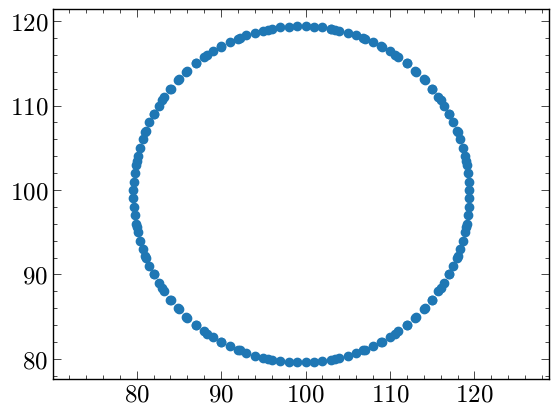

(30.0, 33.0)

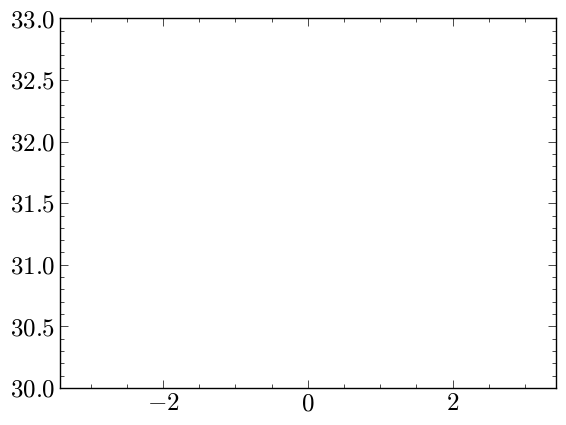

In [ ]:
phi = cell.phi
cntr = cell.contour[0]

plt.scatter(cntr[:, 1], cntr[:, 0])
plt.axis("equal")
plt.show()

R_theta = trace_bd(cntr)
plt.plot(R_theta[:, 0], R_theta[:, 1])
plt.ylim([30, 33])

# Misc

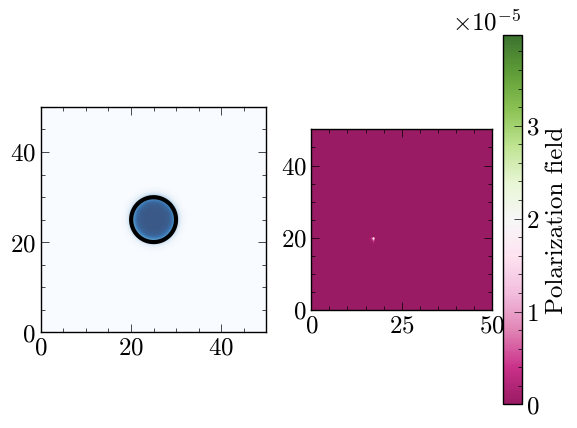

TypeError: update() missing 1 required positional argument: 's'

In [ ]:
cell = Cell(config_file, simbox)
phi = cell.phi
p_field = np.zeros(shape=phi.shape)
p_field[125:150, 30:45] = 16000
p_field[70:80, 25:40] = 900
p_field[70:80, 60:70] = 900

p_field *= phi**2 * (1-phi)**2

dt = simbox.dt
tau = 3
D = 0.5

plt.subplot(121)
plt.imshow(
    cell.phi, extent=[0, L_box, 0, L_box], origin="lower", cmap="Blues", alpha=0.8
)
plt.contour(
    cell.phi,
    levels=[0.5],
    extent=[0, L_box, 0, L_box],
    origin="lower",
    linewidths=[3],
    colors=["black"],
)
plt.subplot(122)
plt.imshow(
    p_field, extent=[0, L_box, 0, L_box], origin="lower", cmap="PiYG", alpha=0.9
)
cbar = plt.colorbar()
cbar.set_label("Polarization field")
plt.show()

###################

for i in range(3000):
    update(cell, p_field)    

###################

plt.subplot(121)
plt.imshow(
    cell.phi, extent=[0, L_box, 0, L_box], origin="lower", cmap="Blues", alpha=0.8
)
plt.contour(
    cell.phi,
    levels=[0.5],
    extent=[0, L_box, 0, L_box],
    origin="lower",
    linewidths=[3],
    colors=["black"],
)
plt.subplot(122)
plt.imshow(
    p_field, extent=[0, L_box, 0, L_box], origin="lower", cmap="PiYG", alpha=0.9
)
cbar = plt.colorbar()
cbar.set_label("Polarization field")
plt.show()


In [ ]:
cntr = ha.find_contour(cell.phi)[0]
dx = simbox.dx
plt.scatter(cntr[:, 1]*dx, cntr[:, 0]*dx)
plt.ylim([0, 50])
plt.xlim([0, 50])


In [ ]:
phi_f = cell.phi
cell_o = Cell(config_file, simbox)
phi_o = cell_o.phi



In [ ]:
plt.imshow(
    phi_f - phi_o, extent=[0, L_box, 0, L_box], origin="lower", cmap="Blues", alpha=0.8
)
plt.colorbar()

In [ ]:
def norm_vec(field, dx):
    grad_x, grad_y, _ = ha.compute_gradients(field, dx)
    grad_phi = np.array([grad_x, grad_y])
    norm_grad_phi = np.sqrt(np.sum(grad_phi * grad_phi, axis=0))
    n_field = -1 * grad_phi / (norm_grad_phi + 1e-10)
    return n_field

In [ ]:
x = np.arange(0, N_mesh, 1)
xg, yg = np.meshgrid(x, x)

nx, ny = norm_vec(phi_o, dx)

cntr = ha.find_contour(phi_o)[0]
x_indx = list(map(int, cntr[:, 1]))
y_indx = list(map(int, cntr[:, 0]))

qx = np.zeros(shape=nx.shape)
qy = np.zeros(shape=nx.shape)

qx[y_indx, x_indx] = nx[y_indx, x_indx]
qy[y_indx, x_indx] = ny[y_indx, x_indx]

plt.scatter(cntr[:, 1], cntr[:, 0], color="red")
plt.quiver(xg, yg, qx, qy, scale_units="inches", scale=2)
plt.axis("equal")

In [ ]:
x = np.arange(0, N_mesh, 1)
xg, yg = np.meshgrid(x, x)

nx, ny = norm_vec(phi_f, dx)

cntr = ha.find_contour(phi_f)[0]
x_indx = list(map(int, cntr[:, 1]))
y_indx = list(map(int, cntr[:, 0]))

qx = np.zeros(shape=nx.shape)
qy = np.zeros(shape=nx.shape) 

qx[y_indx, x_indx] = nx[y_indx, x_indx]
qy[y_indx, x_indx] = ny[y_indx, x_indx]

plt.scatter(cntr[:, 1], cntr[:, 0], color="red")
plt.quiver(xg, yg, qx, qy, scale_units="inches", scale=2)
plt.axis("equal")

In [ ]:
div_F = np.sum(np.gradient([qx.flatten(), ny.flatten()], dx, axis=1), axis=0).reshape(nx.shape)

plt.imshow(div_F, extent=[0, L_box, 0, L_box], origin="lower")
cbar = plt.colorbar()
cbar.set_label(r"$\nabla \cdot \hat{n}$")
plt.tight_layout()